In [1]:
# Module import
from IPython.display import Image
import sys
import pandas as pd

# To use interact -- IPython widget
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')
# local imports
#from gaia_analytic_toymodel import *

from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const
import frame_transformations as ft
from agis import Agis
from agis import Calc_source
from agis_functions import *

from analytic_plots import *

# Ipython magics
%load_ext autoreload
%autoreload 2
# %matplotlib notebook 

# Set some user-specific variables
# MAIN_FOLDER = '../' # relative path to project folder
# FIG_FOLDER = 'figures/' # relative path to figure

# Steps: 
* Source detection
* scan

Create three example stars from real data. The Source object takes as inputs:

> Source('name', $\alpha$, $\delta$, parallax, $\mu_{\alpha}$, $\mu_{\delta}$, $\mu_{r}$)

with units: [string, deg, deg, mas, mas/yr, mas/yr, km/s]

Once the satellite and its correspondent attitude object is created, we need to create a scanner. At the moment, the scaner is only able to perform the search of one single star in the sky.  
_**Scanner:**_
The scanner takes in two parameters. The first does a scan of the sky taking the dot product of the x-axis of the scanner (with respect to the LMN-frame) and the star's position (also in LMN). Since the scanning law has an almost perfect coverage of the sky (would be interesting to do a density plot of where it scans more in the future), it selects the times when the star is in this circle field of view. For this example we set it to 20 deg. The second input parameters sets the z-axis value threshold for the scanner ccd dimentions. That is to say, the height of the scanning line that swaps the sky.  
_**To scan:**_
Firstly, the coarse scan is performed, using the desire satellite and the star that we want to scan.
Secondly, we search for the optimized solutions with the fine scan, which uses the data from the coarse scan.

In [27]:
# # create all the objects we will need:
# parameters for the notebook
t_init = 0 
t_end = 365*5
my_dt = 1/24 # [days]

# objects
gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt)
print('Sat created')
attitude = [101.28, -16.7161, 379.21, -546.05, -1223.14, -7.6]
sirio = Source("sirio",attitude[0], attitude[1], attitude[2], attitude[3], attitude[4], attitude[5] )
print('Source created')
scanSirio = Scanner() 
print('Scanner created')

Sat created
Source created
Scanner created


In [3]:
np.random.seed(seed=1)  # numpy seed set to increase reproducibility
my_observations = np.random.randint(low=t_init, high=t_end, size=10)
my_observations = np.sort(my_observations)
print('my_observations: {}'.format(my_observations))
for t_j in my_observations:
    sirio.set_time
sirio.set_time

my_observations: [ 144  235  715  847  905  960 1061 1096 1669 1791]


<bound method Source.set_time of <source.Source object at 0x7f503d87e3c8>>

In [4]:
for t_L in my_observations:
    print(gaia.func_attitude(t_L))
gaia.func_attitude(my_observations[0]).w

Quaternion(-0.48586098567103725 + 0.1522814944099188 i + 0.858174411764659 j + -0.0654685272129405 k)
Quaternion(0.6797531588636481 + 0.5669406049167081 i + 0.3750207040010589 j + -0.2754513842443333 k)
Quaternion(0.5430511639204602 + 0.4338174009315955 i + 0.6025761862124781 j + -0.3921732217059367 k)
Quaternion(-0.826737404472442 + 0.15340167988065784 i + 0.3435253724267971 j + -0.41828639370052695 k)
Quaternion(0.2394631193503199 + 0.9162069112179033 i + -0.08702551678981478 j + -0.3092715145871489 k)
Quaternion(0.2945153487628543 + 0.3843067242054504 i + -0.8310254670246059 j + -0.27379869289334796 k)
Quaternion(-0.4613706528360669 + -0.24188628769022155 i + -0.6927119549823656 j + -0.4987767957248754 k)
Quaternion(-0.5629320954319493 + -0.7434620150498167 i + 0.007232616201246505 j + -0.36099775258794375 k)
Quaternion(-0.22364831882377884 + -0.5521383435405973 i + -0.7206035830359999 j + 0.35476070131177373 k)
Quaternion(-0.12711259062830865 + -0.34539650540415984 i + 0.8788081453

-0.48586098567103725

In [5]:
# scanSirio.start(gaia, sirio, ti=t_init, tf=t_end)
print('How many wide times?  {}'.format(len(scanSirio.times_wide_scan)))
print('How many coarse times?  {}'.format(len(scanSirio.times_coarse_scan)))
print('How many observation time?  {}'.format(len(scanSirio.obs_times)))
print('How many roots?  {}'.format(len(scanSirio.roots)))
# pd.DataFrame(scanSirio.roots)

How many wide times?  0
How many coarse times?  0
How many observation time?  0
How many roots?  0


# Agis test

In [6]:
sirio.mu_radial

-7.6

In [7]:
# initialize the parameters. Here cheating since initializing knowing the real parameters
s = np.zeros(5)
a = np.zeros(4)
sirio.reset()  # resets the source parameters at time t=0
#for i, t_L in enumerate(my_observations):
s[0] = sirio.alpha*0.9
s[1] = sirio.delta*0.9
s[2] = sirio.parallax
s[3] = sirio.mu_alpha_dx
s[4] = sirio.mu_delta
a[0] = gaia.func_attitude(0).w*0.5
a[1] = gaia.func_attitude(0).x*0.5
a[2] = gaia.func_attitude(0).y*0.5
a[3] = gaia.func_attitude(0).z*0.5

my_sirio = Calc_source('sirio', my_observations, s, a, sirio.mu_radial) 
Solver = Agis(gaia, [my_sirio], [sirio])

In [8]:
my_sirio.s_params

array([ 1.59090252e+00, -2.62575885e-01,  3.79210000e+02, -5.22974860e+02,
       -1.22314000e+03])

In [9]:
my_sirio.s_params

array([ 1.59090252e+00, -2.62575885e-01,  3.79210000e+02, -5.22974860e+02,
       -1.22314000e+03])

In [10]:
Solver.compute_source_observations_parameters()

In [11]:
Solver.verbose = True

In [12]:
Solver.calc_sources[0].s_params.shape

(5,)

In [28]:
print(gaia.s_x.get_coeffs().shape)
print(gaia.s_x.get_knots().shape)

(43801,)
(43798,)


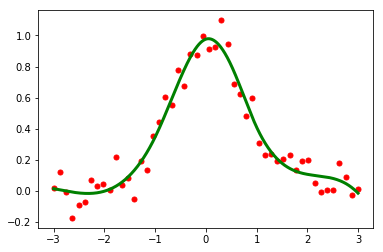

knots: [-3.  -1.  -0.5  0.   0.5  1.   3. ]


In [39]:
from scipy.interpolate import LSQUnivariateSpline, UnivariateSpline
import matplotlib.pyplot as plt
x = np.linspace(-3, 3, 50)
y = np.exp(-x**2) + 0.1 * np.random.randn(50)
t = [-1, -0.5, 0, 0.5, 1]
spl = LSQUnivariateSpline(x, y, t)
xs = np.linspace(-3, 3, 1000)
plt.plot(x, y, 'ro', ms=5)
plt.plot(xs, spl(xs), 'g-', lw=3)
plt.show()
print('knots: {}'.format(spl.get_knots()))

In [42]:
gaia.s_x.get_coeffs().shape[0]

43801

In [41]:
print(365*5)
gaia.s_x.get_knots()

1825


array([0.00000000e+00, 1.04166667e-01, 1.45833333e-01, ...,
       1.82485417e+03, 1.82489583e+03, 1.82500000e+03])

In [32]:
interpolate.InterpolatedUnivariateSpline(t_list, w_list, k=k)
t = my_observations[0]
gaia.s_x.get_knots()[np.where(gaia.s_x.get_knots()>t)][0:4]
gaia.s_x.get_coeffs()[np.where(gaia.s_x.get_knots()>t)][0] = 1
gaia.s_x.get_coeffs()[np.where(gaia.s_x.get_knots()>t)][0]

-0.3144256773286666

In [16]:
Solver.error_function()

0.34038102778220347

In [17]:
Solver.iterate()

***** Iteration: 1 *****
initializing N_ss of shape: (5, 5)
initializing N_aa of shape: (4, 4)
du_dalpha.shape: (10, 3)
du_ds.shape: (5, 3, 10)
S_du_ds shape: (5, 3, 10)
Error before iteration: 0.34038102778220347
du_dalpha.shape: (10, 3)
du_ds.shape: (5, 3, 10)
S_du_ds shape: (5, 3, 10)
h: [[ 1.74808665]
 [-1.94503112]
 [-0.85539637]
 [ 0.88347637]
 [-1.90971632]
 [ 3.19764938]
 [ 0.42963134]
 [-2.45538438]
 [-0.50636406]
 [ 1.75342954]]
dim d: (5,)
(5,)
Error after iteration: 0.34038102778220347


# Other parts of the code

initializing N_ss of shape: (5, 5)
du_dalpha.shape: (10, 3)
du_ds.shape: (5, 3, 10)
S_du_ds shape: (5, 3, 10)
update shape (5, 5)


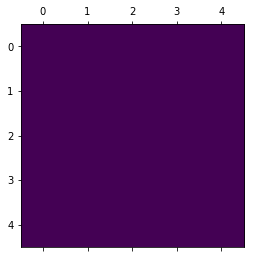

In [123]:
Solver.init_blocks()
# print(Solver.N_ss)
A = Solver.N_ss
A[np.where(A!=0)] = 1
plt.matshow(A, fignum=None)

# Plots:

<IPython.core.display.Javascript object>


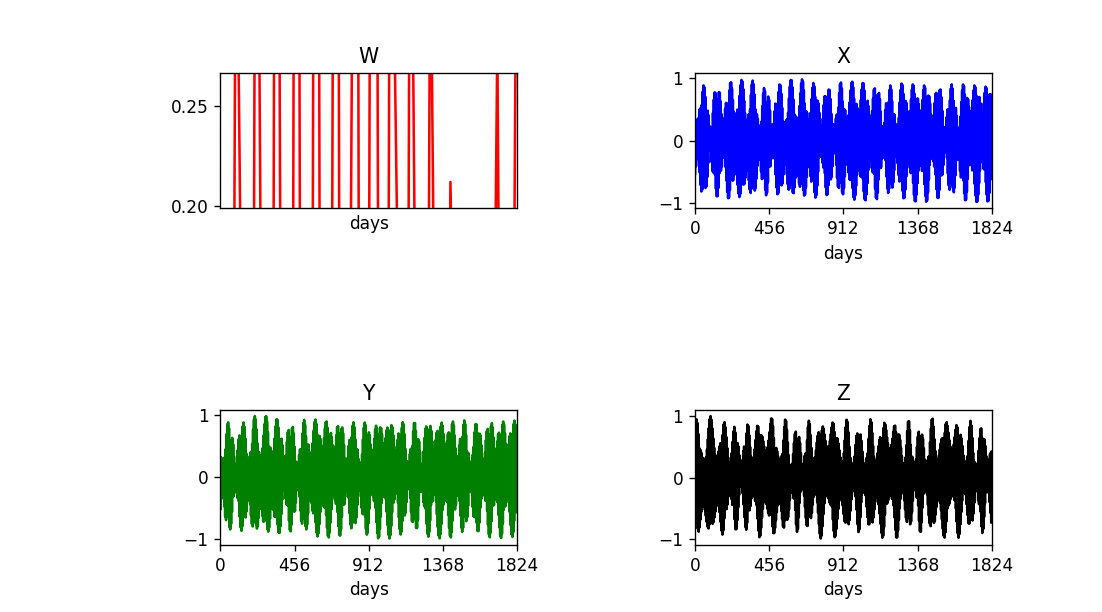

In [7]:
plot_attitude(gaia,t_init,t_end)

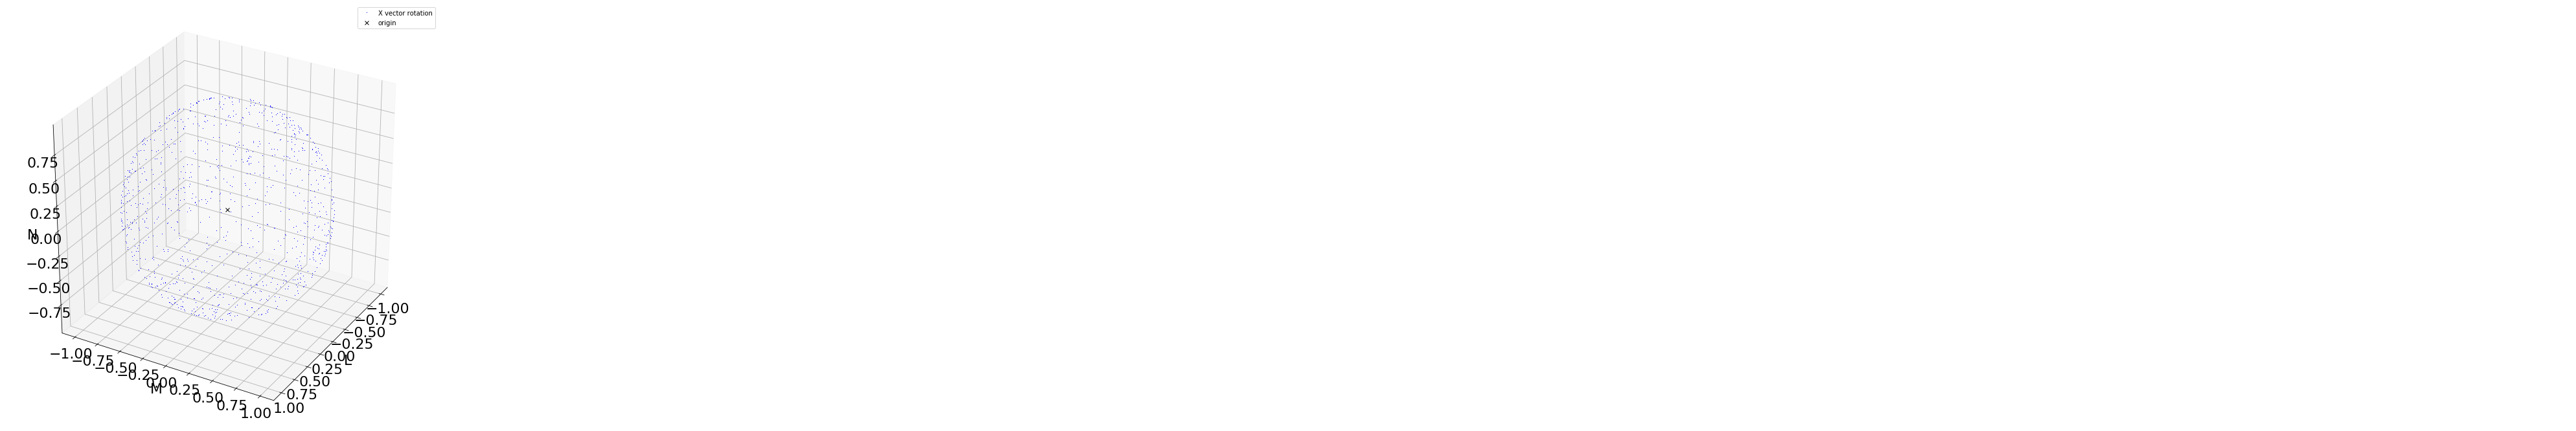

In [8]:
plot_3D_scanner_pos(gaia, 'X', t_init, t_end, 1000, elevation=30, azimuth=30)
#plot_3D_scanner_pos(gaia, 'Z', 0, myTime, 1000)
def my_func(elev, azim):
    plot_3D_scanner_pos(gaia, 'X', t_init, t_end, 1000, elevation=elev, azimuth=azim)
# interact(my_func, elev=widgets.IntSlider(min=0,max=90,step=1,value=20),
#         azim=widgets.IntSlider(min=0,max=90,step=1,value=20))

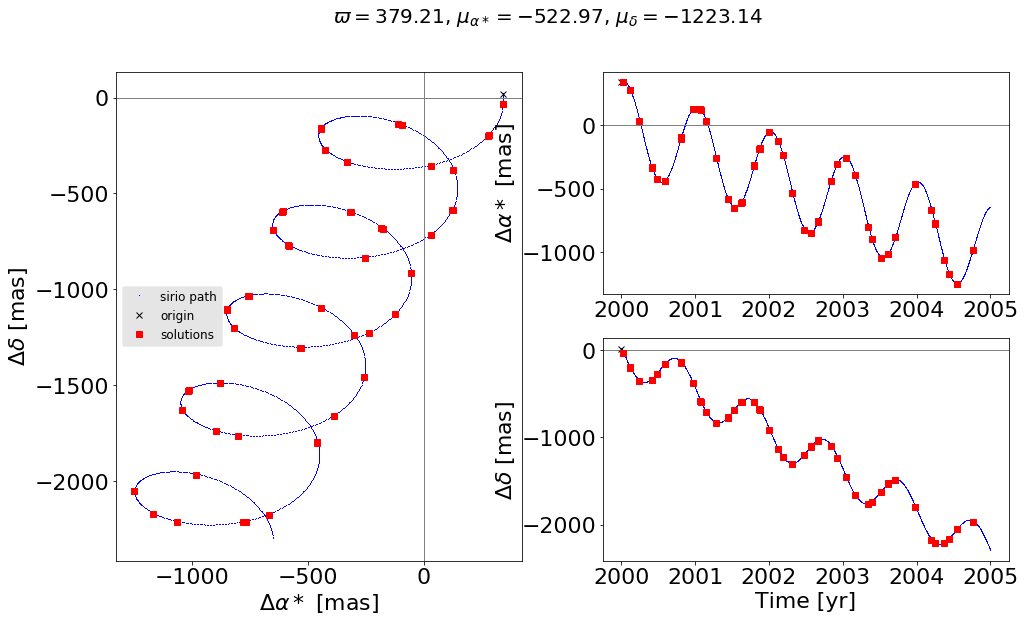

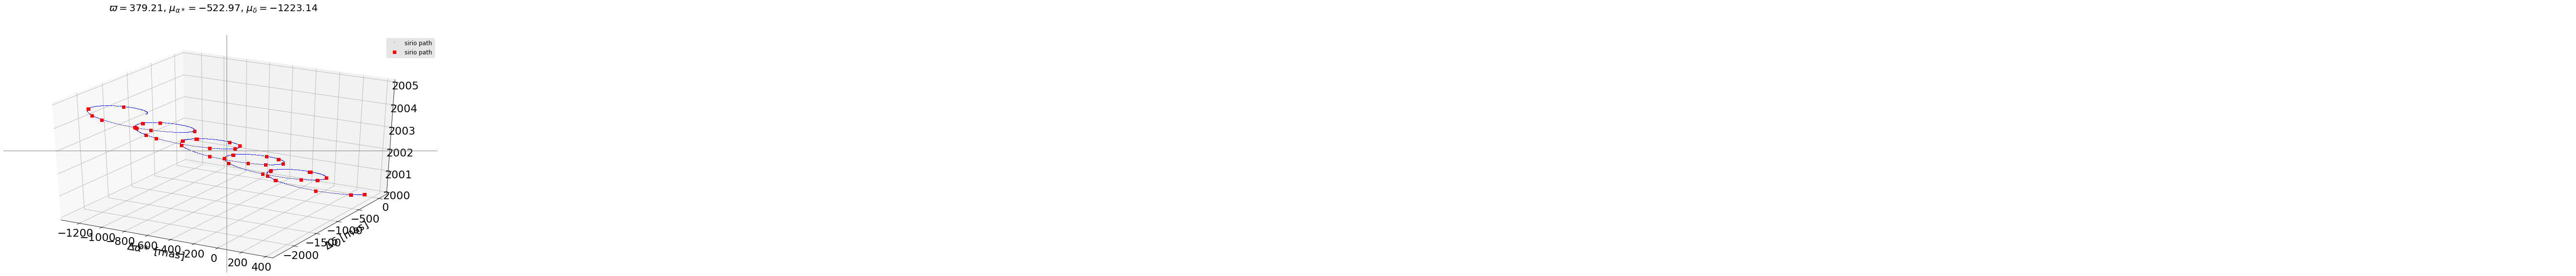

In [44]:
#Plot of the star trayectory from G-frame 
#(i.e. at a point moment around the sun in ecliptic plane in circular orbit of 1 AU).
plot_stars_trajectory(sirio, gaia, scanSirio.obs_times)
plot_stars_trajectory_3D(sirio, gaia, scanSirio.obs_times)

/home/zampieri/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


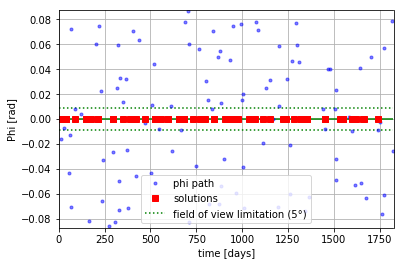

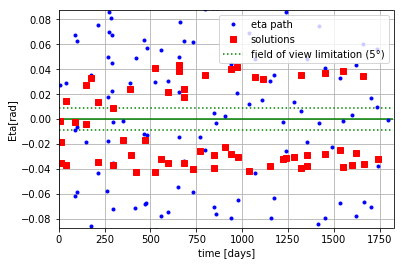

In [6]:
p_phi, p_eta = plot_phi_solutions(sirio, gaia, scanSirio.obs_times, ti=t_init, tf=t_end, n=1000)
p_phi.show()
p_eta.show()

/home/zampieri/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


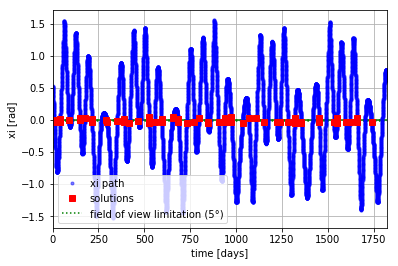

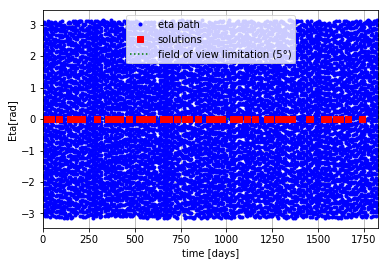

In [8]:
p_xi, p_eta = plot_field_angles(sirio, gaia, scanSirio.obs_times, ti=t_init, tf=t_end, n=10000)
p_xi.show()
p_eta.show()

In [ ]:
from scipy.interpolate import interp1d
x = np.linspace(0, 10, num=11, endpoint=True)
y = np.cos(-x**2/9.0)
f = interp1d(x, y, kind='linear')
f2 = interp1d(x, y, kind='cubic')

In [ ]:
plot_star(sirio, gaia, scanSirio)

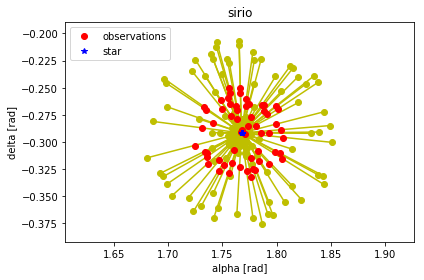

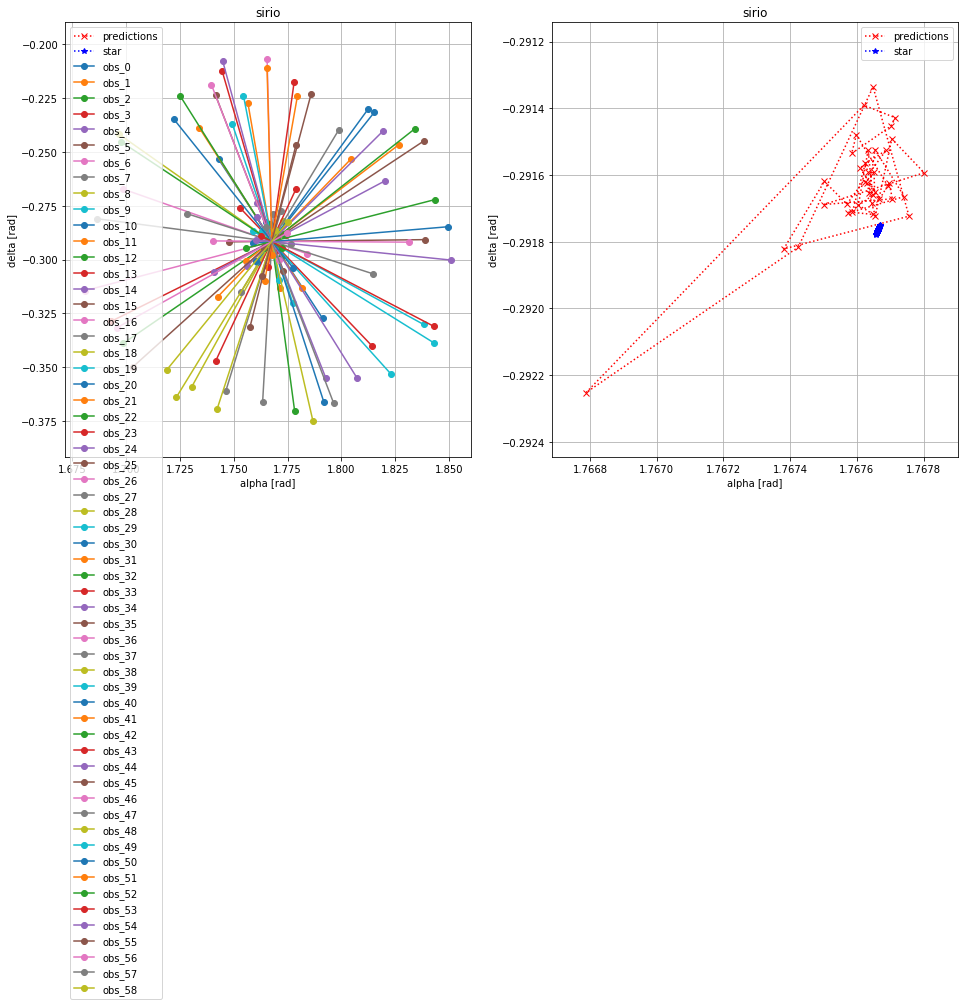

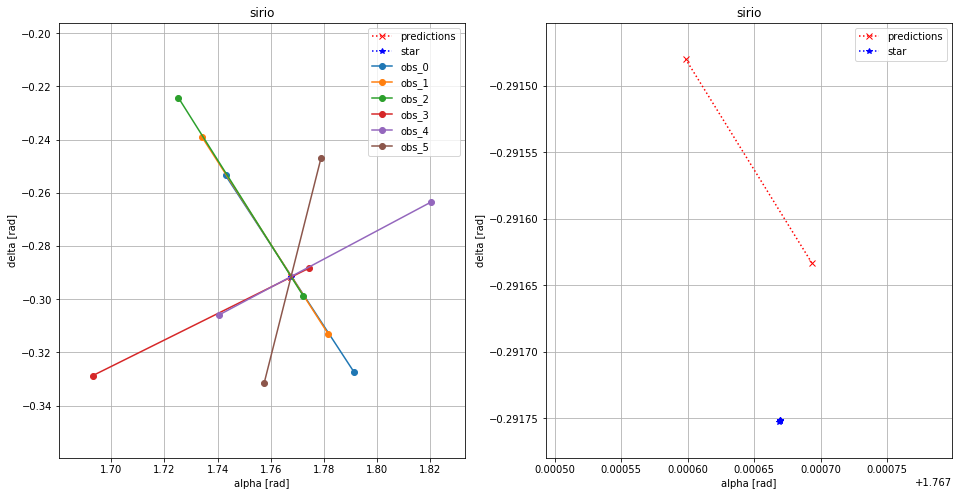

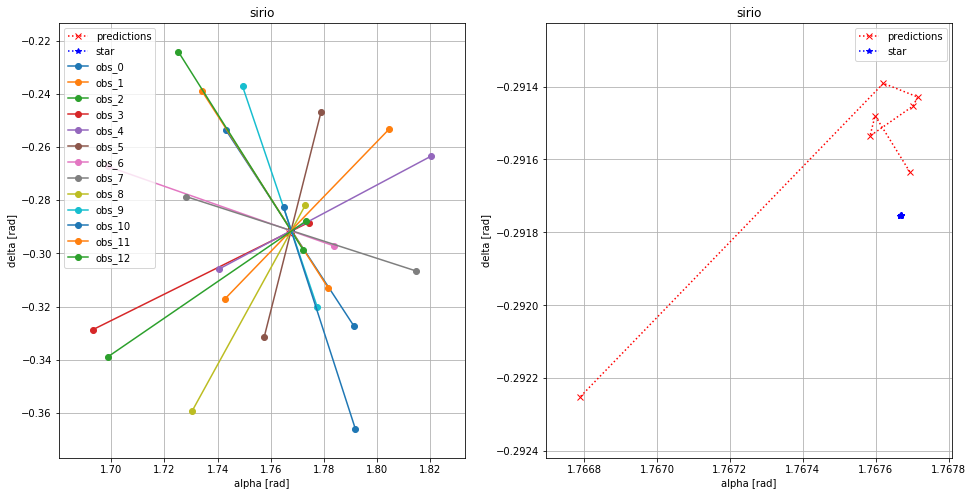

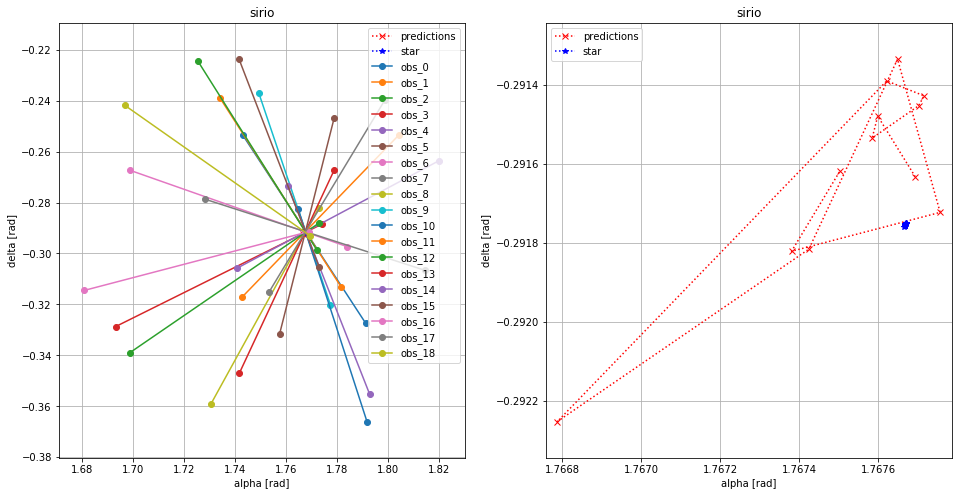

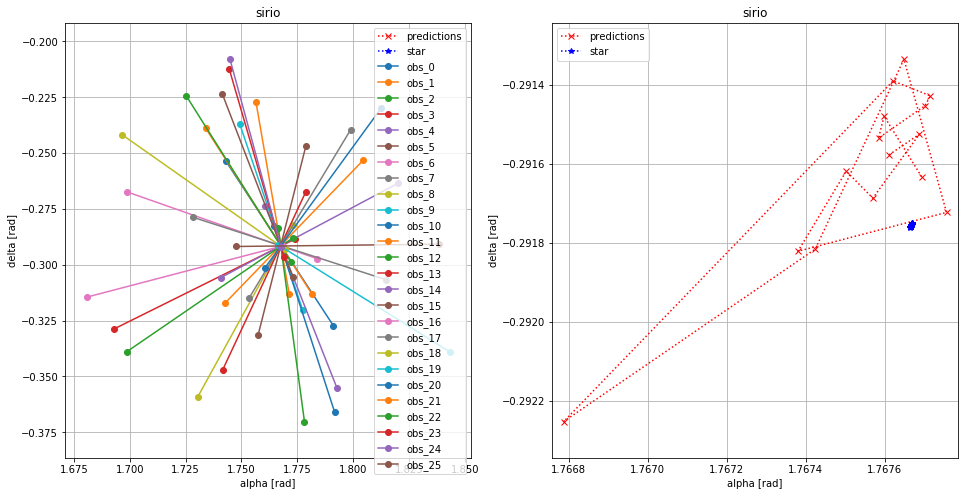

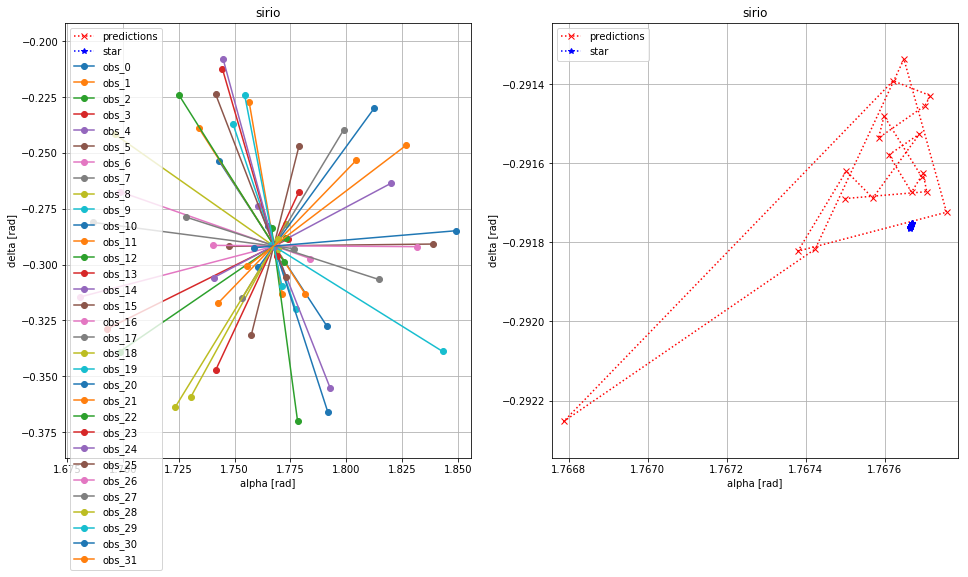

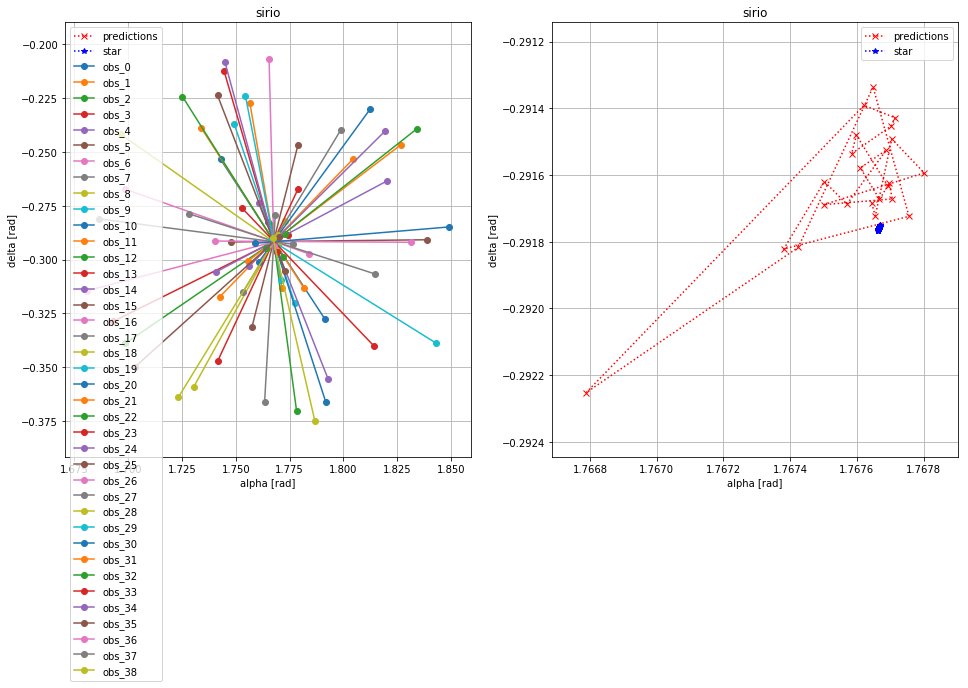

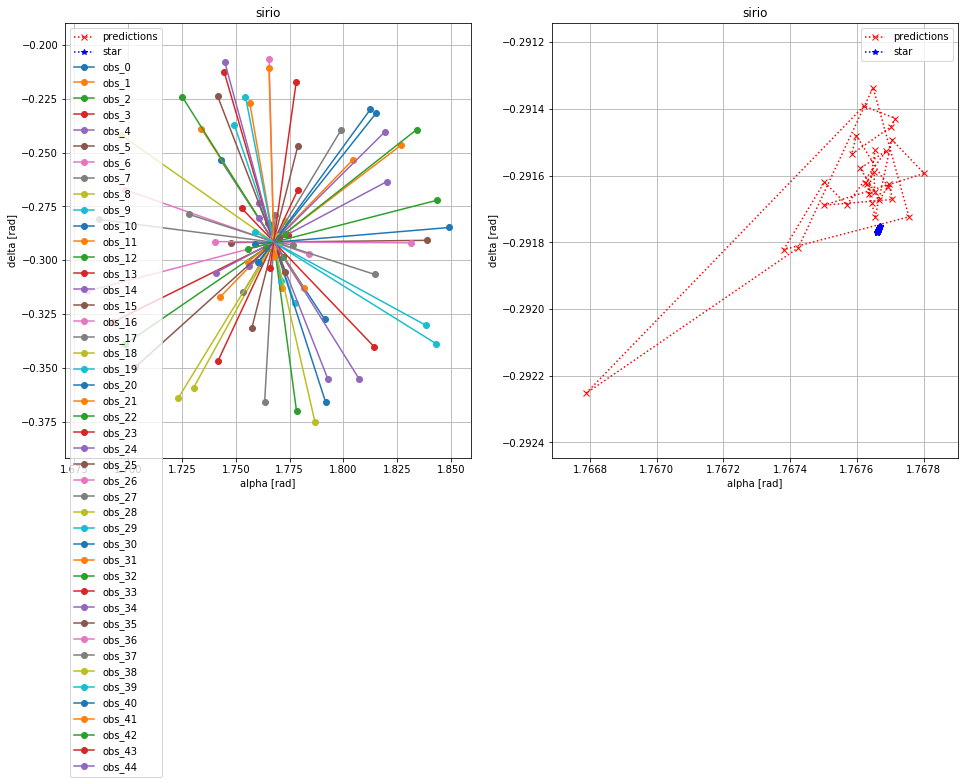

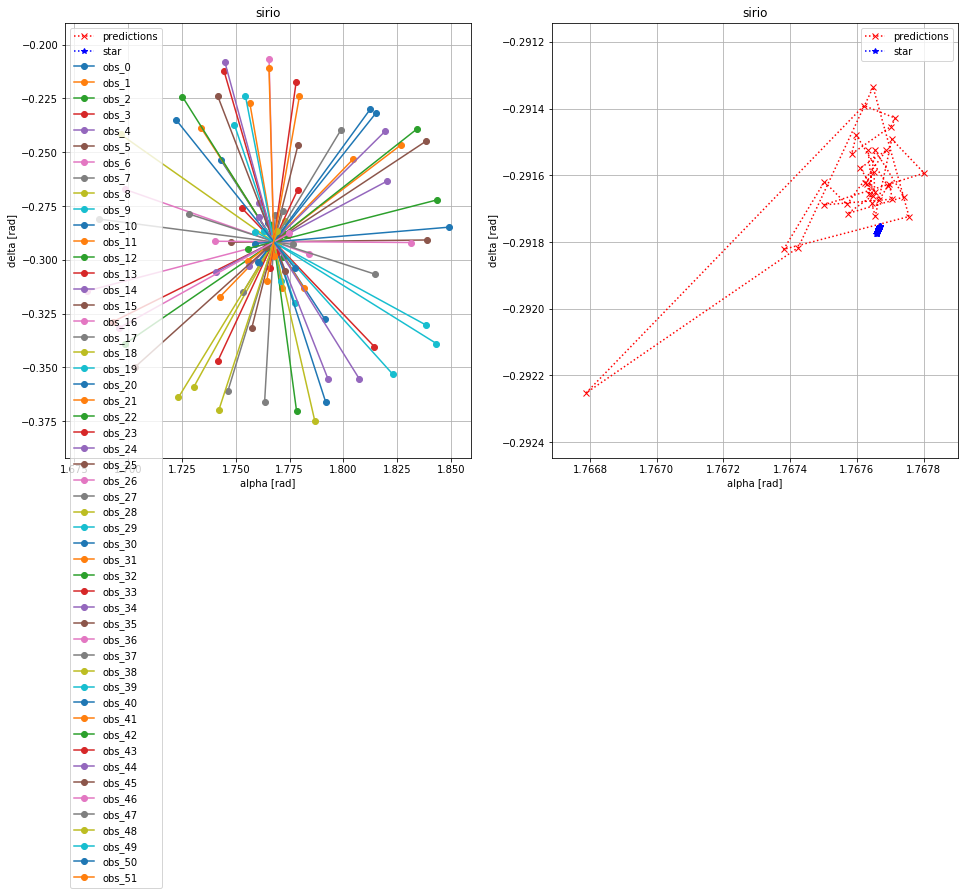

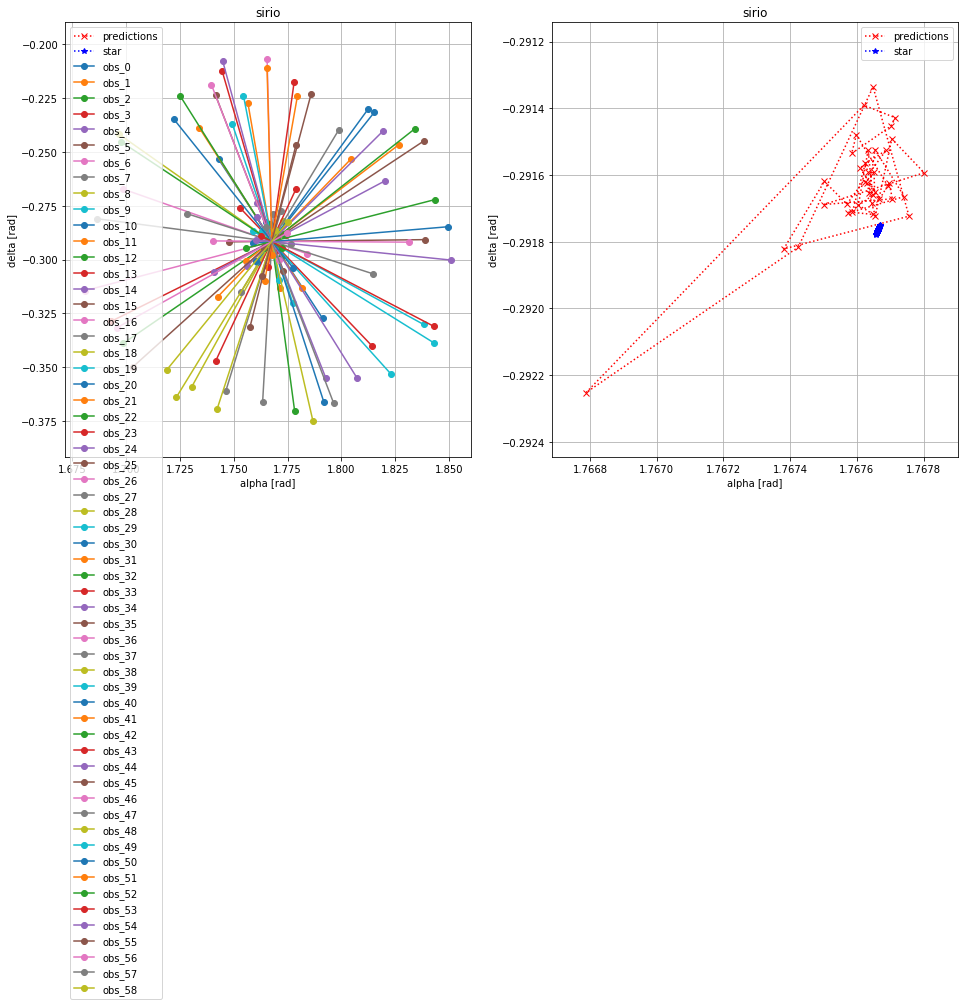

In [7]:
plot_observations(sirio, gaia, scanSirio)
plots = []

for x in np.linspace(0,len(scanSirio.obs_times),10, dtype=int):
    p = plot_prediction_VS_reality(sirio, gaia, scanSirio, x, angle_tolerance=0.2)
    plots.append(p)
    p.savefig('figures/tmp/counting_'+str(x)+'observations',format='png',transparent=False,facecolor='w')

## data exploration and tests

gaia archive:

In [ ]:
df = pd.read_csv('../data/GaiaSource_1584380076484244352_2200921635402776448.csv',
                 sep=None , delimiter=None, header='infer', engine='python', verbose=True, nrows=100)

In [ ]:
df.head(0)

In [25]:
# df['source_id'].value_counts()

**Autograd**

In [27]:
import autograd
from autograd import jacobian
from autograd import grad
import autograd.numpy as np
from autograd.extend import primitive, defvjp
from autograd.test_util import check_grads

def double_sin(x, y):
    out = np.array([np.sin(x), np.cos(y), 1])
    return out  # np.append(out, 2)


# print(double_sin( np.array([1,2]) ))
my_grad = jacobian(double_sin, argnum=0)
print(my_grad(np.pi, np.pi/2))

[-1. -0. -0.]


In [55]:
@primitive
def my_func(x):
    """Numerically stable log(sum(exp(x))), also defined in scipy.misc"""
    return np.sin(x)

def my_func_vjp(ans, x):
    x_shape = x.shape
    return lambda g: np.full(x_shape, g) * np.cos(x)

# Now we tell Autograd that logsumexmp has a gradient-making function.
defvjp(my_func, my_func_vjp)

der_my_func = jacobian(my_func)
for my_point in [np.array([np.pi]), np.array([np.pi/4]),  np.array([np.pi/2])]:
    print(der_my_func(my_point), np.cos(my_point))

[[-1.]] [-1.]
[[0.70710678]] [0.70710678]
[[6.123234e-17]] [6.123234e-17]


In [30]:
@primitive
def logsumexp(x):
    """Numerically stable log(sum(exp(x))), also defined in scipy.misc"""
    max_x = np.max(x)
    return max_x + np.log(np.sum(np.exp(x - max_x)))

def logsumexp_vjp(ans, x):
    x_shape = x.shape
    return lambda g: np.full(x_shape, g) * np.exp(x - np.full(x_shape, ans))

# Now we tell Autograd that logsumexmp has a gradient-making function.
defvjp(logsumexp, logsumexp_vjp)

def example_func(y):
    z = y**2
    lse = logsumexp(z)
    return np.sum(lse)

grad_of_example = grad(example_func)
my_array = np.linspace(-10, 10, 10)
print('Shape of my array: {}'.format(my_array.shape))
print("Gradient: \n", grad_of_example(my_array))

# Check the gradients numerically, just to be safe.
check_grads(example_func, modes=['rev'])(my_array)

Shape of my array: (10,)
Gradient: 
 [-1.00000000e+01 -5.41430436e-17 -5.24119093e-30 -8.29707084e-39
 -1.42061150e-43  1.42061150e-43  8.29707084e-39  5.24119093e-30
  5.41430436e-17  1.00000000e+01]
